# Winter 2023 scRNA-seq analysis module part 2 (dimenstionality reduction through trajectory inference)

Please make sure you are using the kernel entitled "Python [conda env:scanpy_2021]" for this exercise.

## scRNA-seq experiments of day 21 reprogramming intermediates cultured under fibroblast condition, naive pluripotent and trophoblast stem cell conditions

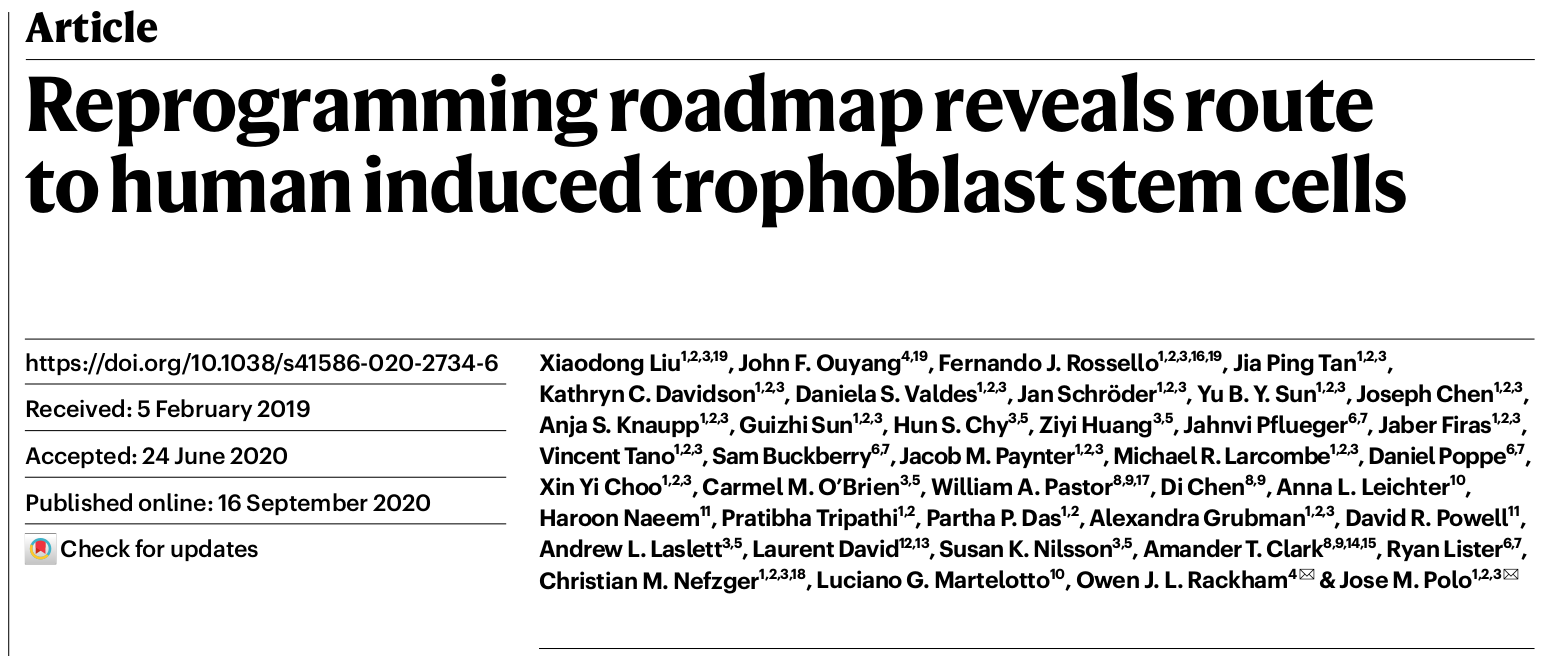

In [1]:
#Article from which the data was obtained
from IPython.display import Image
Image("Liu_et_al_2020.png")

This dataset was downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150637

## Experimental Design

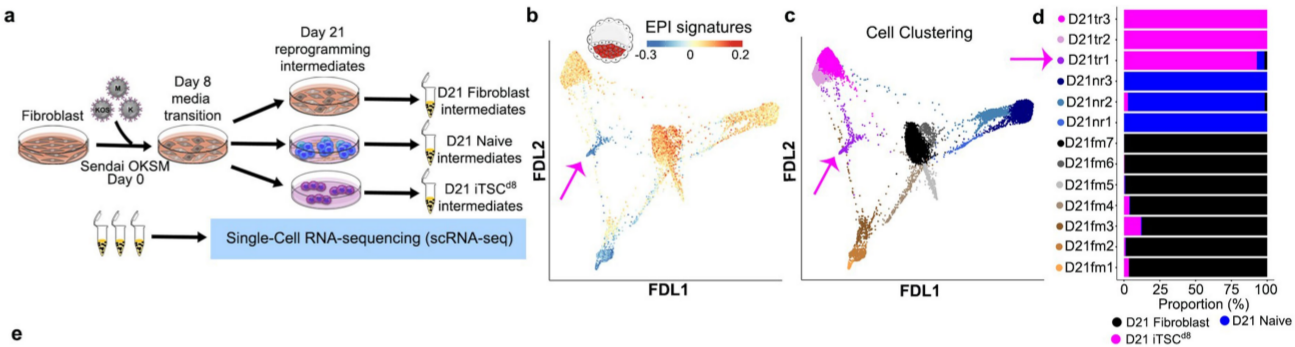

In [2]:
from IPython.display import Image
Image("Experimental_Design.png")

## 1 Import Python packages/libraries to use in analysis¶

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import warnings;
warnings.filterwarnings('ignore');
from gprofiler import GProfiler
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=170, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_header()
results_file = './liu2020_part2.h5ad'
results_file_denoised = './liu2020_deno_part2.h5ad'

# Reload the data to restart analysis

In [ ]:
adata = sc.read('./data/adata_section1_02072023.h5ad')
adata.uns['log1p']["base"] = None 

take a look at the data

In [ ]:
adata

## 2.5 Dimenstionality Reduction Methods: Visualization and Summarization

There are two main objectives of dimensionality reduction methods: visualization and summarization. Visualization is the attempt to optimally describe the dataset in two or three dimensions. These reduced dimensions are used as coordinates on a scatter plot to obtain a visual representation of the data. Summarization does not prescribe the number of output components. Instead, higher components become less important for describing the variability present in the data. Summarization techniques can be used to reduce the data to its essential components by finding the inherent dimensionality of the data, and are thus helpful for downstream analysis.


Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated.

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data. One criticism is that they neglect the local density of data points in the original space, often resulting in misleading visualiza-
tions where densely populated subsets of cells are given more visual space than warranted by their transcriptional diversity
in the dataset.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

# However, there is some debate...

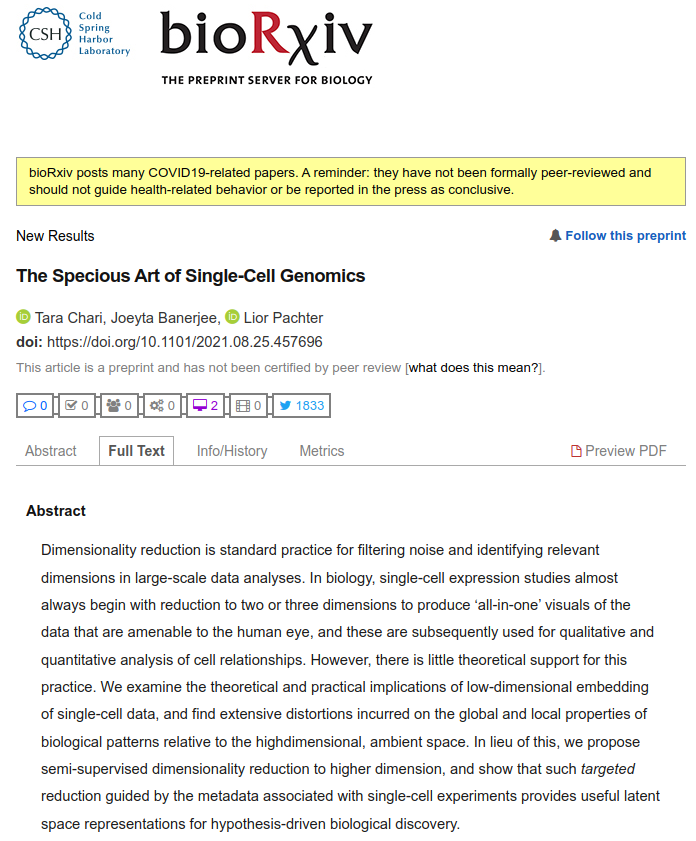

In [3]:
from IPython.display import Image
Image("liorPachter_2021.png")

Here's what Lior says on twitter:
"It's time to stop making t-SNE & UMAP plots. In a new preprint w/ Tara Chari we show that while they display some correlation with the underlying high-dimension data, they don't preserve local or global structure & are misleading. They're also arbitrary.Threadhttps://biorxiv.org/content/10.1101/2021.08.25.457696v1"


and...


"Ok.. but.. maybe t-SNE & UMAP (or your favorite 2D viz) aren't perfect, but they are "canonical" and not arbitrary. Nope. They're just art."

In [ ]:
# Calculate the visualizations
# Note that this step will take ~10 mins to run
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
#sc.tl.draw_graph(adata) #Note we won't run this visualization because it can be really slow to generate!

In [ ]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
#sc.pl.draw_graph(adata, color='n_counts') #Note we won't run this visualization because it can be really slow to generate!

PCA:
- Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
- The plot usually will not show the expected clustering of the data in two dimensions unless your data is not very heterogenous as ours is

t-SNE:
- Shows several distinct clusters with clear subcluster structure
- Connections between clusters are difficult to interpret visually

UMAP:
- Data points are spread out on the plot showing several clusters
- Connections between clusters can be readily identified

Diffusion Maps:
- Shows connections between regions of higher density
- Very clear trajectories are suggested, but clusters are less clear
- Each diffusion component extracts heterogeneity in a different part of the data

Graph: (not generated)
- Does not show much new information when compared to the others but often will show clear connections between the clusters and hint at stem cell clusters

The strengths and weaknesses of the visualizations might not be readily identified in the above plots. However, generally t-SNE exaggerates differences (but sacrafices accurate global distance representation in favor of local distance), diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

One way to make the above run faster is to use the elbow method to figure out how many PC's to use

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Before and after batch correction or after dimensionality reduction it is a good idea to take a look at how your different batches clustered

In [ ]:
sc.pl.umap(adata, color=['n_counts', 'batch'], alpha=0.5, size=25)

In [ ]:
sc.pl.draw_graph(adata, color='batch')

## 2.6 Cell Cycle Scoring

So far we have tried to correct for known sources of technical variation in the data (e.g. batch, count depth). There are also known sources of biological variation that can explain the data and also can be corrected for (e.g. cell cycle). This data correction can be performed by a simple linear regression against a cell cycle score as implemented in the Scanpy and Seurat platforms (Butler et al, 2018; Wolf et al, 2018) or in specialized packages with more complex mixture models such as scLVM (Buettner et al, 2015) or f-scLVM (Buettner et al, 2017). Lists of marker genes to compute cell cycle scores are obtained from the literature (Macosko et al, 2015). These methods can also be used to regress out other known biological effects such as mitochondrial gene expression, which is interpreted as an indication of cell stress. Several aspects should be considered prior to correcting data
for biological effects. Firstly, correcting for biological covariates is not always helpful to interpret scRNA-seq data. While removing cell cycle effects can improve the inference of developmental trajectories (Buettner et al, 2015; Vento-Tormo et al, 2018), cell cycle signals can also be informative of the biology. 

Here, we will use a gene list from Macosko et al., Cell (2015) to score the cell cycle effect in the data and classify cells by cell cycle phase. Please note, the gene list was generated for human HeLa cells. We perform cell cycle scoring on the full batch-corrected data set in adata.

In [ ]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table('./Macosko_cell_cycle_genes.txt', delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_ens = adata.var_names[np.in1d(adata.var_names, s_genes)] #in1d = Test whether each element of a 1-D array is also present in a second array
g2m_genes_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_ens, g2m_genes=g2m_genes_ens)

In [ ]:
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)

None of our clusters show a pronounced signal and look like they are dividing

If we did want to regress out a set of genes we would do something like:

In [ ]:
#sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
#sc.pp.scale(adata)

# 3 Downstream analysis

## 3.1 Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see sc.pp.pca() and sc.pp.neighbors() functions used in the visualization section.


Modularity optimization via louvain has a stochastic element to it. This stochasticity typically does not affect the biological interpretation of the data, but can change the details of analysis scripts. Normally scanpy fixes the random seed to 0 to make scripts exactly reproducible.

In [ ]:
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

In [ ]:
adata.obs['louvain_r0.5'].value_counts()

In [ ]:
adata.obs['louvain_r1'].value_counts()

In [ ]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette='Set2',legend_loc='on data')
sc.pl.umap(adata, color=['n_counts'])
sc.pl.umap(adata, color=['batch'])

At a resolution of 0.5 the broad clusters in the visualization are captured well in the data. It remanins to be seen if cluster 3 in the 0.5 resolution should be two clusters instead of one (as in the 1 resolution). The covariate plots show that none of the clusters have unusually high or low counts, are made up of just the batches, and we could also check for a high percent mitochondria if we wanted to determine if some of the clusters seem to represent stressed or dying cells.

To look at differences in clustering algorithms we will cluster cells using the Leiden algorithm [Traag18], an improved version of the Louvain algorithm [Blondel08]. It has been proposed for single-cell analysis by [Levine15].

It might also be interesting to take a look at 0.75 resolution as well

In [ ]:
sc.tl.louvain(adata, resolution=0.75, key_added='louvain_r0.75')
sc.tl.leiden(adata, key_added='leiden_r1')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(adata, resolution=0.75, key_added='leiden_r0.75')
sc.pl.umap(adata, color=['louvain_r1', 'leiden_r1'], palette='Set2',legend_loc='on data')

Now I want to see what the 0.75 resolution looks like:

In [ ]:
sc.pl.umap(adata, color=['louvain_r0.75', 'leiden_r0.75'], palette='Set2',legend_loc="on data")

There is no "right" answer here but I think the Leiden 0.75 looks reasonable. Most likely, you will need to do several different methods and then use your biological knowledge to make the decision.

Next let's look at the "cell type". Remember this is what we named the cells when we first uploaded them:

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75'], palette='Set2')

## 3.2 Marker genes & cluster annotation 

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test. This is the default in scanpy. The test is automatically performed on the .raw data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

Also note that the results are displayed as ranked gene lists instead of genes that have a p-value below some cut-off. This is because the test treats each cell as an independent replicate leading to very low p-values. It might be useful in some cases to create pseudo-bulk counts.

We can use some known marker genes to annotate the clusters and if we didn't have any information on the cells in question we could run automated annotation using scmap or garnett or the recently published MARS (https://github.com/snap-stanford/mars) as well as do a gene ontolody enrichment analysis.

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.75', key_added='rank_genes_r0.75')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75', groups=['3','4','5'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75', groups=['6','7','8'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75', groups=['9','10','11'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75', groups=['12','13','14'], fontsize=12)

Clusters 5 and 6 look similar. If we wanted to find the differences between these three clusters we could do:

In [ ]:
sc.tl.rank_genes_groups(adata,groupby='leiden_r0.75',groups=['6'],reference='5',key_added='rank_genes_r0.75_clust6')

In [ ]:
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75_clust6', groups=['6'], n_genes=30, sharey=False)

To make things easier to look at we can put everything in a table. Here are the top 20 genes.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_r0.75']['names']).head(20)

If we would like to take a look at some of the marker genes across the groups we can do:

In [ ]:
sc.pl.violin(adata, ['ALPPL2', 'GATA3', 'COL1A1'], groupby='leiden_r0.75')

From here, we can use our biological knowledge to start labeling some of the clusters. However, we have a list from the Liu et al. paper (Supplementary File 3). They write in the methods: "To identify gene signatures, we first define cluster-specific marker genes for each of the 21 snRNA clusters. For each snRNA cluster, we define marker genes as genes that have an average log 2 -transformed fold change (averaged across all 20 pairwise differential expressions) of >1.5, and we also require the genes to be differentially expressed in at least 14 of the 20 pairwise differential expressions. Hierarchical clustering was then performed on the Jaccard similarity of the marker genes (Extended Data Fig. 2f) to identify overlapping gene sets that is, the gene signatures. Overall, we identified eight gene signatures (Supplementary Table 3) that we named fibroblast (snRNA-FM1, snRNA-FM2, snRNA-FM3, snRNA-FM4); mixed (snRNA-mix); early-primed (snRNA-PR1); primed: snRNA-PR2, snRNA-PR3, snRNA-PR4); novel intermediate signature (snRNA-nic); naive (snRNA-NR1, snRNA-NR2, snRNA-NR3, snRNA-NR4); non-reprogrammed (nonReprog)1 (snRNA-RE1, snRNA-RE3, snRNA-RE4, snRNA-RE5); nonReprog2 (snRNA-RE6)."

We can use these gene signatures to score each of the clusters and identify them in this manner. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list.

Alternatively, we can calculate an overlap score between data-driven marker genes and provided markers.

Marker gene overlap scores can be quoted as overlap counts, overlap coefficients, or jaccard indices. The method returns a pandas dataframe which can be used to annotate clusters based on marker gene overlaps.

Because they did something similar in Liu et al., lets give it a try and score the clusters:

In [ ]:
#First we will pull in the gene signature lists and do the same thing we did for cell cycle
sig_genes = pd.read_table('./SupTable3.txt', delimiter='\t')
fibroblast = sig_genes['fibroblast'].dropna()
mixed = sig_genes['mixed'].dropna()
early_primed = sig_genes['early-primed'].dropna()
primed = sig_genes['primed'].dropna()
naive = sig_genes['naive'].dropna()
nis = sig_genes['nis'].dropna()
nonReprog1 = sig_genes['nonReprog1'].dropna()
nonReprog2 = sig_genes['nonReprog2'].dropna()

In [ ]:
sc.tl.score_genes(adata, fibroblast, score_name='fibro_score')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','fibro_score'], palette='Set2',legend_loc='on data')

In [ ]:
sc.tl.score_genes(adata, mixed, score_name='mix_score')
sc.tl.score_genes(adata, early_primed, score_name='early_prime_score')
sc.tl.score_genes(adata, primed, score_name='primed_score')
sc.tl.score_genes(adata, naive, score_name='naive_score')
sc.tl.score_genes(adata, nis, score_name='nis_score')
sc.tl.score_genes(adata, nonReprog1, score_name='nonReprog1_score')
sc.tl.score_genes(adata, nonReprog2, score_name='nonReprog2_score')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','mix_score'], palette='Set2',legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','early_prime_score'], palette='Set2',legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','primed_score'], palette='Set2',legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','naive_score'], palette='Set2',legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','nis_score'], palette='Set2',legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','nonReprog1_score'], palette='Set2',legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_r0.75','nonReprog2_score'], palette='Set2',legend_loc='on data')

In [ ]:
#Lets look at everything together
sc.pl.umap(adata, color=['ANPEP','NANOG','ZIC2','DNMT3L','GATA3','fibro_score',
                               'early_prime_score','primed_score','nis_score','naive_score','cell_type','leiden_r0.75'], palette='Set2')

Let's see how our data looks compared to what is published

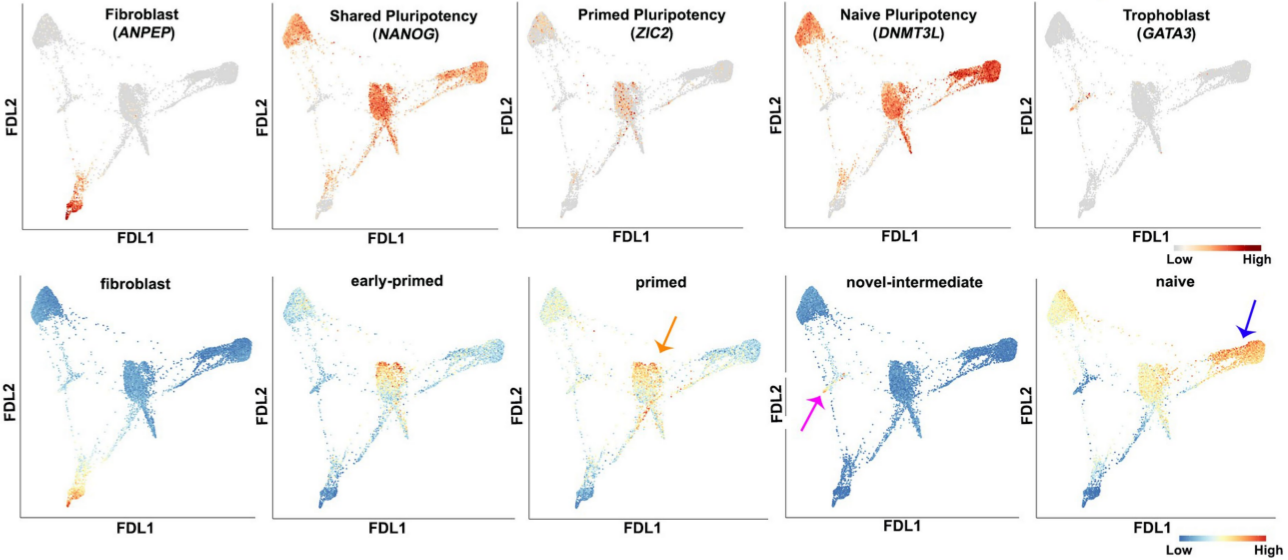

In [4]:
from IPython.display import Image
Image("ExtData_fig9e.png")

At this point we could run the marker gene scoring or take the top "x" genes for each cluster and do an enrichment analysis. However, I think that we are ready to name the clusters using the information that we have.

In [ ]:
new_cluster_names = ['primed1','primed2','naive1','early_primed','naive2','fibro1','fibro2','fibro_nonReprog1','mix1','fibro3','Novel_Inter','mix2', 'nonReprog2','nonReprog1',
                     'mix3']
adata.rename_categories('leiden_r0.75', new_cluster_names)

If we want to export the image we would do that like:

In [ ]:
sc.pl.tsne(adata, color=['leiden_r0.75'], legend_loc='on data' ,title='', frameon=False, 
           legend_fontsize=10, alpha=0.8, size=20, save = 'tsne_renamed_res0_75_winter2023.pdf')

## 3.3 Subclustering 

To build on the basis clustering, we can now subcluster parts of the data to identify substructure within the identified cell types. Here, we subcluster the 'Novel Intermediate' population to see if we can find any difference between these cells in this cluster.

Subclustering is normally performed at a lower resolution than on the entire dataset given that clustering is more sensitive when performed on a small subset of the data.

In [ ]:
#Subcluster novel intermediates
sc.tl.leiden(adata, restrict_to=('leiden_r0.75', ['Novel_Inter']), resolution=0.15, key_added='leiden_r0.75_NIS_sub')

In [ ]:
#Show the new clustering
if 'leiden_r0.75_NIS_sub_colors' in adata.uns:
    del adata.uns['leiden_r0.75_NIS_sub_colors']

sc.pl.umap(adata, color='leiden_r0.75_NIS_sub')
sc.pl.umap(adata, color='nis_score')
sc.pl.umap(adata, color='cell_type')

The novel intermediate cluster broke up into three clusters and now we can find the marker genes in these clusters

In [ ]:
#Get the new marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.75_NIS_sub', key_added='rank_genes_r0.75_NIS_sub')

In [ ]:
#Plot the new marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.75_NIS_sub', groups=['Novel_Inter,0','Novel_Inter,1'], fontsize=12)

Cluster 2 looks like it has some of the same markers seen in a similar report Castel et al. Cell Reports 2020

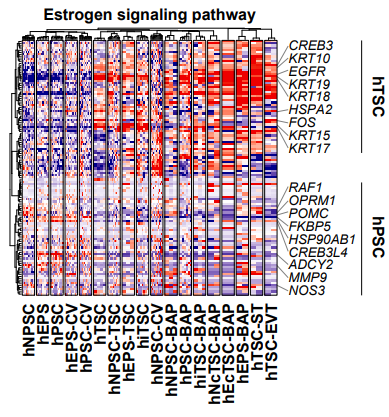

In [5]:
from IPython.display import Image
Image("Castel_et_al_2020_figS5.png")

In [ ]:
adata.obs['leiden_r0.75_NIS_sub'].value_counts()

## 3.4 Trajectory Inference and pseudotime analysis

As our data set contains differentiation processes, we can investigate the differentiation trajectories in the data. This analysis is centred around the concept of 'pseudotime'. In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.

Pseudotime analysis is complicated when there are multiple trajectories in the data. In this case, the trajectory structure in the data must first be found before pseudotime can be inferred along each trajectory. The analysis is then called 'trajectory inference'.

Once the pseudotime variable is inferred, we can test for genes that vary continuously along pseudotime. These genes are seen as being associated with the trajectory, and may play a regulatory role in the potential differentiation trajectory that the analysis found.

Based on a recent comparison of pseudotime methods [Saelens et al., 2018], and time constraints, we will look at 'Diffusion Pseudotime (DPT)'. Different methods perform well on different types of trajectories. For example, 'Slingshot' was the top performer for simple bifurcating and multifurcating trajectories but takes more time and therefore we will skip this time; 'Monocle2' performed best for complex tree structures, and 'DPT' performed well in bifurcating trajectories. As the complexity of trajectories are generally not known, it is adviseable to compare trajectory inference outputs.

Often we would first subset the data to include only the clusters that we care about. After subsetting it is important to recalculate the dimensionality reduction methods such as PCA, and diffusion maps, as the variability of the subsetted data set will be projected onto different basis vectors.

Note that we subset the data to include only the cells we want to examine. Trajectory inference, and especially measuring gene expression changes over pseudotime can be a computationally expensive process, thus we often work with reduced gene sets that are informative of the variance in the data.

In [ ]:
#first I am going to make a copy
adata_copy = adata.copy()
#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_copy, flavor='cell_ranger', n_top_genes=2500, subset=True)

As we have subsetted the data to include only cell types that we assume are of interest, we recalculate the dimension reduction algorithms on this data. This ensures that for example the first few PCs capture only the variance in this data and not variance in parts of the full data set we have filtered out.

In [ ]:
#Recalculating PCA for subset
sc.pp.pca(adata_copy, svd_solver='arpack')
sc.pl.pca(adata_copy)
sc.pl.pca_variance_ratio(adata_copy)

Trajectory inference is often performed on PCA-reduced data, as is the case for Slingshot and Monocle2. To assess how many principal components (PCs) should be included in the low-dimensional representation we can use the 'elbow method'. This method involves looking for the 'elbow' in the plot of the variance ratio explained per PC. Above we can see the elbow at PC6. Thus the first six PCs are included.

In [ ]:
adata_copy.obsm['X_pca'] = adata_copy.obsm['X_pca'][:,0:6]

## 3.4.2 Diffusion Pseudotime (DPT) 

Diffusion pseudotime is integrated into scanpy and is therefore easy to use with the current setup.

DPT is based on diffusion maps, thus a diffusion map representation must be calculated prior to pseudotime inference. This in turn is based on a KNN graph embedding obtained from sc.pp.neighbors().

In [ ]:
sc.pp.neighbors(adata_copy)
sc.tl.diffmap(adata_copy)

In [ ]:
sc.pl.diffmap(adata_copy, components='1,2', color='leiden_r0.75')
sc.pl.diffmap(adata_copy, components='1,3', color='leiden_r0.75')

In DPT we must assign a root cell to infer pseudotime. In the plots we can observe that the most appropriate root will be either the naive1 or the nonReprog1 cells. We will try the nonReprog1 cell because it has the minimum DC1 and the maximum DC2 value.

In [ ]:
#Find the CD4 T cell with the highest DC3 value to act as root for the diffusion pseudotime and compute DPT
stem_mask = np.isin(adata_copy.obs['leiden_r0.75'], 'nonReprog1')
max_stem_id = np.argmin(adata_copy.obsm['X_diffmap'][stem_mask,3])
root_id = np.arange(len(stem_mask))[stem_mask][max_stem_id]
adata_copy.uns['iroot'] = root_id

#Compute dpt
sc.tl.dpt(adata_copy)

In [ ]:
#Visualize pseudotime over differentiation
sc.pl.diffmap(adata_copy, components='1,3', color='dpt_pseudotime')

# 3.5 Partition-based graph abstraction

Partition-based graph abstraction (PAGA) is a method to reconcile clustering and pseudotemporal ordering. It can be applied to an entire dataset and does not assume that there are continuous trajectories connecting all clusters.

As PAGA is integrated into scanpy, we can easily run it on the entire data set. Here we run and visualize PAGA with different clustering inputs.

In [ ]:
sc.tl.paga(adata, groups='leiden_r0.75')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

The close connectivity of the two different subclusters shows the similarity of these cells. This result shows that not all connections in PAGA represent differentiation trajectories, but instead transcriptional similarity between states. Thus, further experiments are required to confirm potential lineage trajectories obtained via PAGA or other trajectory inference methods.

We can do the same visualization on a umap layout.

In [ ]:
sc.pl.paga_compare(adata, basis='umap')

In [ ]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=2, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_PBMCs.pdf', dpi=300, format='pdf')
plt.show()

Implementation note:

Note that the above plotting function only works when sc.pl.paga_compare(adata, basis='umap') is run before. The sc.pl.paga_compare() function stores the correct positions in adata.uns['paga']['pos'] to overlay the PAGA plot with a umap representation. To overlap PAGA with other representation, you can run sc.pl.paga_compare() with other basis parameters before plotting the combined plot.

Regressing out the cell cycle effect will likely change how 'TA' cells are included in the trajectory. In this manner trajectory inference and graph abstraction can be iteratively improved. Trajectory inference and PAGA can be iteratively improved to better represent the biology. Knowing when to stop attempting to improve, or assessing when all of the relevant technical covariates have been taken into account can only be achieved with sufficient knowledge of the biological system, experience, and possibly some luck.

It should also be noted that while an abstracted graph or an inferred trajectory can help to infer a lineage tree, experimental validation is necessary. Key driving forces in lineage specification might be lowly expressed genes and therefore neglected in the graph or even excluded in the HVG filtering.

## 3.6 Write to file

In [ ]:
#Write to file
adata.write('../Liu_et_al_example_winter2023.h5ad')

# 4.0 Summary

In this case study we went through the typical steps of an scRNA-seq data analysis workflow. We started with general preprocessing steps, which included cell and gene quality control, normalization, batch correction, selection of highly variable genes, visualization, and cell cycle scoring. In these steps the overall structure of the data is explored and filtered to produce optimal downstream analysis results. In the downstream scRNA-seq analysis section we then used methods to interpret the data and investigate particular parts of it. These steps included clustering and cluster identification via marker genes, trajectory inference, inferring an abstracted graph to relate clusters and trajectory inference in one visualization, and an example of differential expression although we did not have any experimental conditions to test.

Any individual data analysis script will not always follow all of these steps. For example, trajectory inference may not be relevant where no differentiation processes are captured (this is probably the case with our data). Furthermore, a typical analysis will not always traverse the above steps as linearly as shown here. We have attempted to show this by suggesting how one can move back to data preprocessing to improve trajectory inference or PAGA. Indeed, all downstream analyses may require going back to tweak or add preprocessing steps to improve the downstream analysis results.

A further aspect we stressed in this case study is that one should take care of which stage of data is being used to perform different analysis steps. Uncorrected, normalized data (or raw counts depending on the tool) are generally used for statistical tests where technical covariates such as batch can be included; corrected data should be used to visually compare results as the human eye will not be able to take into account technical differences that confound the comparison. When computing tests such as differential expression or finding marker genes, it is adviseable to use the full data set that is not restricted to find highly variable genes.

In [ ]:
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

## Aside: Using SCRAN on your own data

As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing, and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.